https://www.meteoblue.com/fr/meteo/archive/export?daterange=1985-01-01%20-%202023-07-31&locations%5B%5D=b%25c3%25a2le_suisse_2661604&domain=NEMSAUTO&params%5B%5D=&params%5B%5D=temp2m&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score, validation_curve, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm_notebook

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from itertools import product

In [3]:
tempo = pd.read_csv('data1985_2023.csv')
tempo

C:\Users\PC de MEDUSA\AppData\Local\Temp\ipykernel_4768\791506077.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  tempo = pd.read_csv('data1985_2023.csv')


,location,Bâle
0,lat,47.66652
1,lon,7.50000
2,asl,499.774
3,variable,Temperature
4,unit,°C
...,...,...
341860,20231231T1900,5.145029
341861,20231231T2000,5.415029
341862,20231231T2100,5.995029
341863,20231231T2200,6.465029


In [4]:
#Importation des données
temp = pd.read_csv('data1985_2023.csv')
#temp.dropna(axis=0, inplace=True)
donnee = temp.iloc[:9]
temp = temp.iloc[9:]

C:\Users\PC de MEDUSA\AppData\Local\Temp\ipykernel_4768\283101579.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv('data1985_2023.csv')


In [5]:
donnee

,location,Bâle
0,lat,47.66652
1,lon,7.50000
2,asl,499.774
3,variable,Temperature
4,unit,°C
5,level,2 m elevation corrected
6,resolution,hourly
7,aggregation,NaN
8,timestamp,Bâle Temperature [2 m elevation corrected]


In [6]:
temp

,location,Bâle
9,19850101T0000,0.055028796
10,19850101T0100,0.16502881
11,19850101T0200,0.39502883
12,19850101T0300,0.37502885
13,19850101T0400,0.12502885
...,...,...
341860,20231231T1900,5.145029
341861,20231231T2000,5.415029
341862,20231231T2100,5.995029
341863,20231231T2200,6.465029


In [7]:
#Separer la date de l'heure
temp[['date', 'heure']] = temp['location'].str.rsplit("T", n=1, expand=True)
temp.drop(['location'], axis=1, inplace=True)

# Convertir la colonne de dates en objets de date et d'heure
temp['date'] = pd.to_datetime(temp['date'], format='%Y%m%d')
temp['heure'] = pd.to_datetime(temp['heure'], format='%H%M').dt.time

#Date to index
temp.set_index('date', inplace=True)

temp

,Bâle,heure
date,,
1985-01-01,0.055028796,00:00:00
1985-01-01,0.16502881,01:00:00
1985-01-01,0.39502883,02:00:00
1985-01-01,0.37502885,03:00:00
1985-01-01,0.12502885,04:00:00
...,...,...
2023-12-31,5.145029,19:00:00
2023-12-31,5.415029,20:00:00
2023-12-31,5.995029,21:00:00


In [8]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341856 entries, 1985-01-01 to 2023-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Bâle    341856 non-null  object
 1   heure   341856 non-null  object
dtypes: object(2)
memory usage: 7.8+ MB


In [9]:
#Verifier le type des données
temp.dtypes

Bâle     object
heure    object
dtype: object

In [10]:
#Str to numeric values
temp['Bâle'] = pd.to_numeric(temp['Bâle'], errors='coerce')

temp.dtypes

Bâle     float64
heure     object
dtype: object

In [11]:
#Remplir les veleurs manquantes par des valeurs de la ligne precedente
temp.ffill()

,Bâle,heure
date,,
1985-01-01,0.055029,00:00:00
1985-01-01,0.165029,01:00:00
1985-01-01,0.395029,02:00:00
1985-01-01,0.375029,03:00:00
1985-01-01,0.125029,04:00:00
...,...,...
2023-12-31,5.145029,19:00:00
2023-12-31,5.415029,20:00:00
2023-12-31,5.995029,21:00:00


In [12]:
#Extraction des veleurs significatives
temperature = temp.groupby(['date'])['Bâle'].agg(['max', 'min', 'mean'])

temperature

,max,min,mean
date,,,
1985-01-01,0.645029,-0.034971,0.275445
1985-01-02,0.435029,-3.444971,-1.721638
1985-01-03,-1.164971,-3.394971,-2.576221
1985-01-04,-0.954971,-17.884972,-12.532471
1985-01-05,-7.554971,-14.414971,-9.989554
...,...,...,...
2023-12-27,11.585029,-0.504971,4.156695
2023-12-28,10.735029,7.375029,8.385862
2023-12-29,11.575029,7.335029,9.506696


In [13]:
#Verifier le type des index
temperature.index

DatetimeIndex(['1985-01-01', '1985-01-02', '1985-01-03', '1985-01-04',
               '1985-01-05', '1985-01-06', '1985-01-07', '1985-01-08',
               '1985-01-09', '1985-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='date', length=14244, freq=None)

In [14]:
def duree_data(data):
    nbr_de_jours = len(temperature.index.day)
    nbr_d_annees = len(temperature.index.year.unique())
    print(nbr_de_jours, 'days')
    print(nbr_d_annees, 'years')

In [15]:
duree_data(temperature)

14244 days
39 years


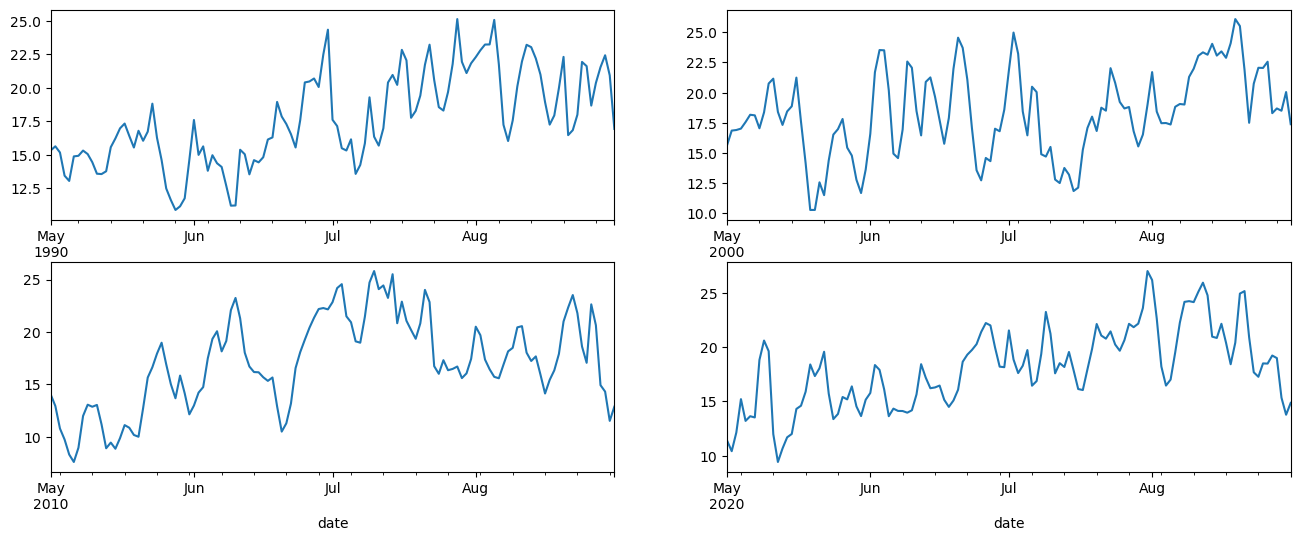

In [10]:
plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
temperature['1990-05':'1990-08']['mean'].plot()
plt.subplot(2,2,2)
temperature['2000-05':'2000-08']['mean'].plot()
plt.subplot(2,2,3)
temperature['2010-05':'2010-08']['mean'].plot()
plt.subplot(2,2,4)
temperature['2020-05':'2020-08']['mean'].plot()
plt.show()

# Détermination de la stationnarité

In [16]:
#J'ai enlevé le mois 1 et 2 de 1985 et le mois 12 de 2023 car ils designent in demi-saison et cela peut perturber notre data lors 
#de l'entrainement

#temperature = temperature['1985-03':'2023-11']
temperature_mensuelle = temperature.groupby(temperature.index.month).mean()
temperature_annuelle = temperature.groupby(temperature.index.year).mean()
temperature['mois'] = temperature.index.month

In [17]:
#extraire les données de chaque saison des années
automne = temperature[ temperature['mois'].isin([9, 10, 11]) ]
hiver = temperature[ temperature['mois'].isin([12, 1, 2]) ]
printemps = temperature[ temperature['mois'].isin([3, 4, 5]) ]
ete = temperature[ temperature['mois'].isin([6, 7, 8]) ]

In [18]:
automne

,max,min,mean,mois
date,,,,
1985-09-01,21.985027,10.185029,16.085028,9
1985-09-02,24.145027,13.265029,17.373779,9
1985-09-03,17.815027,12.035029,14.483362,9
1985-09-04,19.415028,11.325029,14.345029,9
1985-09-05,20.405027,11.215029,15.873779,9
...,...,...,...,...
2023-11-26,5.025029,2.605029,3.706695,11
2023-11-27,5.875029,1.765029,3.787945,11
2023-11-28,3.145029,-0.124971,1.242529,11


In [21]:
def time_plot(data, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    
    sns.lineplot(data[y_col], ax=ax, color='mediumblue', label='Temperature journaliere')

    second = data.groupby([pd.Grouper(freq='M')]).mean()
    sns.lineplot(second[y_col], ax=ax, color='red', label='temperature mensuelle')     
    
    ax.set(xlabel="Date", ylabel="Temperature", title=title)
    
    sns.despine()

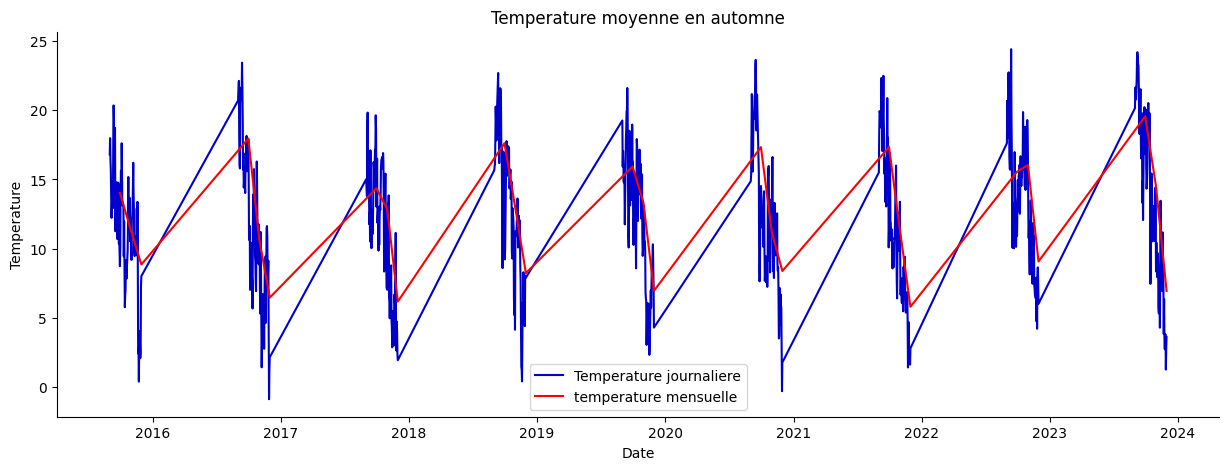

In [22]:
time_plot(automne['2015':'2023'], 'mean', 'Temperature moyenne en automne')

In [23]:
def get_diff(data, nom):
    diff = data.diff()
    diff = diff.bfill()

    #diff.to_csv(nom + '_diff_stationnaire.csv')
    return diff

In [24]:
automne_statio = get_diff(automne, 'automne')

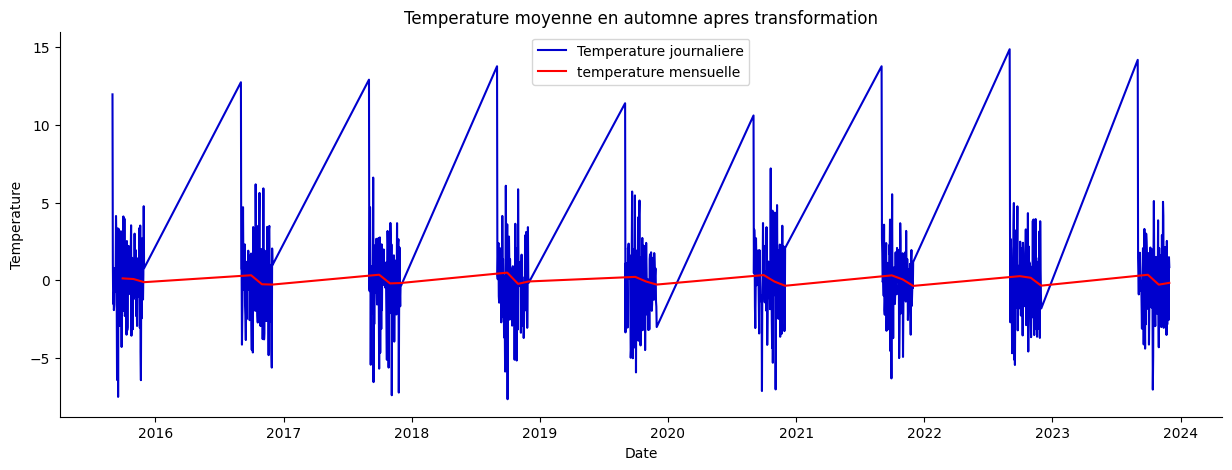

In [25]:
time_plot(automne_statio['2015':'2023'], 'mean', 'Temperature moyenne en automne apres transformation')

# Observing Lags


In [30]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index

    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(20, 5), color='mediumblue')
    smt.graphics.plot_acf(data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

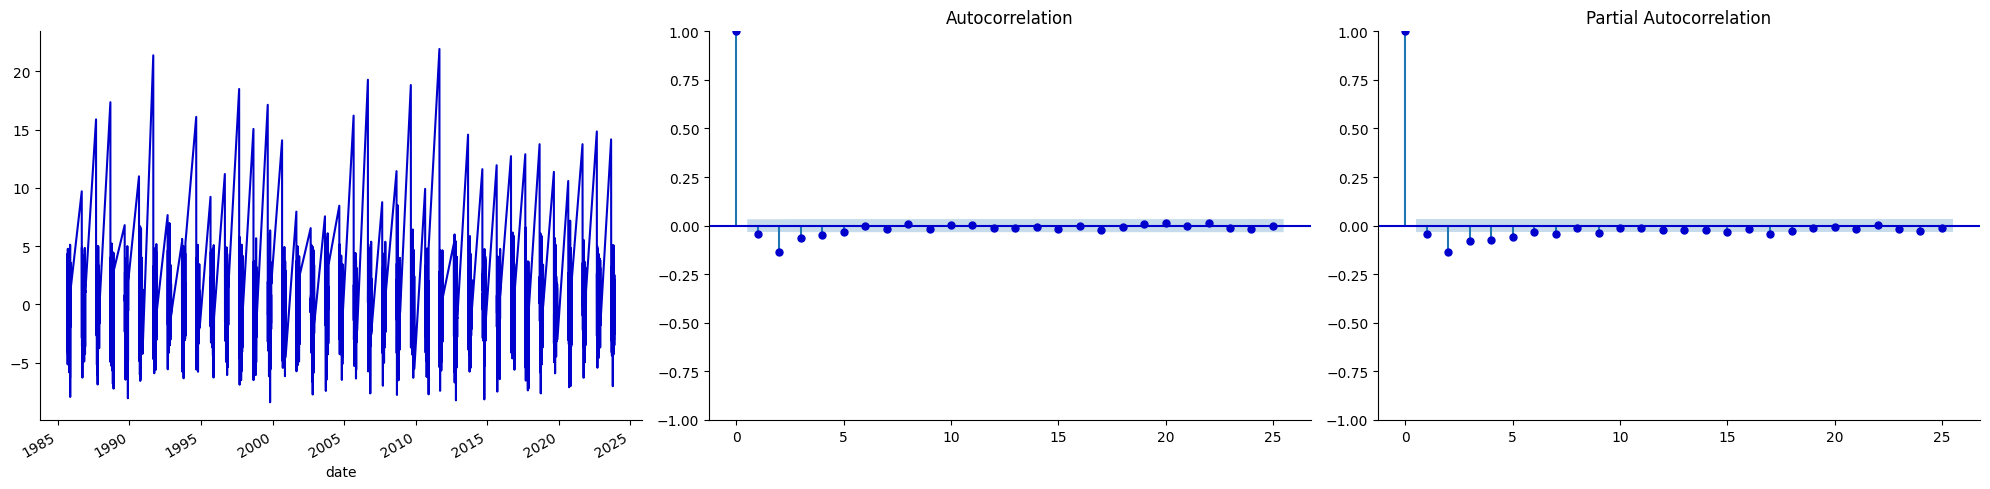

In [31]:
plots(automne_statio['mean'], lags=25)


In [12]:
#Valeur à predire : valeurCible n'est que la colonne mean décalé par un jour avant
temperature['valeurCible'] = temperature.shift(-1)['mean']

temperature

,max,min,mean,valeurCible
date,,,,
1985-01-01,0.645029,-3.294971,-0.327888,-0.093305
1985-01-02,0.645029,-1.404971,-0.093305,-2.441638
1985-01-03,-1.444971,-3.444971,-2.441638,-5.059138
1985-01-04,-0.954971,-14.424971,-5.059138,-12.670805
1985-01-05,-8.394971,-17.884972,-12.670805,-9.969554
...,...,...,...,...
2023-07-27,26.305029,8.185029,17.651695,19.691278
2023-07-28,26.845028,11.365029,19.691278,19.505862
2023-07-29,21.785028,16.225029,19.505862,18.963778


In [13]:
#Remplir les veleurs manquantes par des valeurs de la ligne precedente
#Particulièrement pour la dérnière ligne

temperature = temperature.ffill()
temperature

,max,min,mean,valeurCible
date,,,,
1985-01-01,0.645029,-3.294971,-0.327888,-0.093305
1985-01-02,0.645029,-1.404971,-0.093305,-2.441638
1985-01-03,-1.444971,-3.444971,-2.441638,-5.059138
1985-01-04,-0.954971,-14.424971,-5.059138,-12.670805
1985-01-05,-8.394971,-17.884972,-12.670805,-9.969554
...,...,...,...,...
2023-07-27,26.305029,8.185029,17.651695,19.691278
2023-07-28,26.845028,11.365029,19.691278,19.505862
2023-07-29,21.785028,16.225029,19.505862,18.963778


Les deux graphiques sont des graphiques d'autocorrélation (ACF) et de corrélation partielle (PACF) de la moyenne mensuelle des stations météorologiques d'automne de 2015 à 2023.

Le graphique ACF mesure la corrélation entre une série temporelle et elle-même décalée d'un certain nombre de périodes. Le graphique PACF mesure la corrélation entre une série temporelle et elle-même décalée d'un certain nombre de périodes, après avoir éliminé l'effet des corrélations à des ordres inférieurs.

### Graphique ACF

Le graphique ACF de la moyenne mensuelle des stations météorologiques d'automne montre une forte autocorrélation aux premiers ordres, ce qui signifie que la valeur moyenne d'un mois donné est fortement corrélée à la valeur moyenne du mois précédent. L'autocorrélation diminue progressivement à des ordres plus élevés, mais reste significative jusqu'à l'ordre 24.

### Graphique PACF

Le graphique PACF de la moyenne mensuelle des stations météorologiques d'automne montre une forte corrélation partielle au premier ordre, ce qui signifie que la valeur moyenne d'un mois donné est fortement corrélée à la valeur moyenne du mois précédent, même après avoir éliminé l'effet de la corrélation entre la valeur moyenne du mois donné et la valeur moyenne du mois précédent. La corrélation partielle aux ordres supérieurs n'est pas significative.

### Conclusion

Les graphiques ACF et PACF de la moyenne mensuelle des stations météorologiques d'automne montrent que la moyenne mensuelle de la température est une série temporelle autocorrélée, avec une forte autocorrélation au premier ordre. Cela signifie que la valeur moyenne d'un mois donné est fortement corrélée à la valeur moyenne du mois précédent.

### Implications:
Cette autocorrélation peut être exploitée pour prédire la valeur moyenne de la température d'un mois donné en fonction de la valeur moyenne du mois précédent. Cependant, il est important de noter que l'autocorrélation diminue progressivement à des ordres plus élevés, ce qui signifie que les prédictions basées sur des ordres plus élevés seront moins précises.

## 1ere methode : Ridge-Lasso

In [21]:
model_1 = Ridge(alpha=0.1)
model_2 = Lasso(alpha=0.1, selection='cyclic')

In [22]:
col_entrainement = temperature.columns[temperature.columns.isin(['max', 'min', 'mean'])]
col_entrainement

Index(['max', 'min', 'mean'], dtype='object')

In [23]:
automne_entrainement = automne[:'2017-11']
automne_test = automne['2018-09':]
automne_entrainement

,max,min,mean,valeurCible
date,,,,
1985-09-01,21.525028,13.925029,18.907112,17.075445
1985-09-02,24.145027,10.185029,17.075445,15.177529
1985-09-03,17.815027,12.605029,15.177529,14.090029
1985-09-04,15.995029,12.035029,14.090029,15.940445
1985-09-05,20.405027,11.325029,15.940445,13.880029
...,...,...,...,...
2017-11-26,4.165029,0.655029,2.848779,3.610029
2017-11-27,6.955029,-0.584971,3.610029,4.509195
2017-11-28,6.225029,2.935029,4.509195,3.489612


In [24]:
hiver_entrainement = hiver[:'2018-02']
hiver_test = hiver['2018-12':]
hiver_entrainement

,max,min,mean,valeurCible
date,,,,
1985-12-01,11.815029,1.885029,5.528362,6.575862
1985-12-02,13.835029,2.235029,6.575862,8.248362
1985-12-03,15.875029,2.445029,8.248362,9.137112
1985-12-04,16.105028,3.325029,9.137112,7.299612
1985-12-05,14.025029,1.815029,7.299612,7.687112
...,...,...,...,...
2018-02-24,3.705029,-3.274971,-0.519971,-4.072888
2018-02-25,-0.164971,-6.804971,-4.072888,-6.612888
2018-02-26,-4.224971,-8.214971,-6.612888,-6.318721


In [25]:
printemps_entrainement = printemps[:'2018-05']
printemps_test = printemps['2019-03':]
printemps_entrainement

,max,min,mean,valeurCible
date,,,,
1985-03-01,14.145029,1.775029,7.934196,6.387945
1985-03-02,8.945029,2.315029,6.387945,5.099196
1985-03-03,9.585029,0.145029,5.099196,6.802112
1985-03-04,9.475029,4.845029,6.802112,6.136279
1985-03-05,8.355029,4.635029,6.136279,6.357112
...,...,...,...,...
2018-05-27,28.915028,16.465029,22.830862,21.106278
2018-05-28,27.055029,15.795029,21.106278,19.249195
2018-05-29,24.995028,13.015029,19.249195,20.354612


In [26]:
ete_entrainement = ete[:'2017-08']
ete_test = ete['2018-06':]
ete_entrainement

,max,min,mean,valeurCible
date,,,,
1985-06-01,21.325027,7.905028,14.616695,14.574195
1985-06-02,19.295029,10.155029,14.574195,14.840029
1985-06-03,22.155027,8.055029,14.840029,17.025028
1985-06-04,27.035028,8.755029,17.025028,16.765445
1985-06-05,23.105028,9.895029,16.765445,17.740029
...,...,...,...,...
2017-08-27,31.125029,16.295029,24.844612,24.724611
2017-08-28,30.065027,19.525028,24.724611,23.187528
2017-08-29,30.645027,15.475029,23.187528,23.111695


In [27]:
l = np.logspace(-5, 5, 11)
k = np.linspace(0.1, 0.9, 9)
Cv = KFold(33)

In [28]:
cross_val_score(model_1, hiver_entrainement[col_entrainement], hiver_entrainement['valeurCible'], cv=Cv, scoring='r2')

array([0.80349616, 0.75938923, 0.64935168, 0.39164397, 0.68225921,
       0.79773103, 0.72330624, 0.74828698, 0.61047832, 0.7294475 ,
       0.61345021, 0.81673856, 0.79425524, 0.69457034, 0.66587218,
       0.64717127, 0.80411089, 0.81285905, 0.57104547, 0.71054403,
       0.59134325, 0.76083396, 0.73093647, 0.68793456, 0.71618039,
       0.67180706, 0.861025  , 0.67219383, 0.46632617, 0.63472857,
       0.52862973, 0.79616824, 0.72821033])

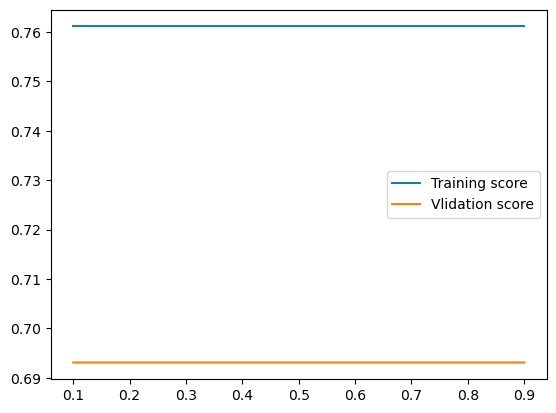

In [29]:
train_score, val_score = validation_curve(model_1, hiver_entrainement[col_entrainement], hiver_entrainement['valeurCible'], param_name='alpha', param_range=k, cv=Cv, scoring='r2')

plt.plot(k, train_score.mean(axis=1), label='Training score')
plt.plot(k, val_score.mean(axis=1), label='Vlidation score')
plt.legend()
plt.show()

In [30]:
param_grid = {'alpha': np.linspace(0.1, 0.9, 9)}
#'metric': ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol']
grid = GridSearchCV(model_2, param_grid, cv=Cv)
grid.fit(hiver_entrainement[col_entrainement], hiver_entrainement['valeurCible'])

GridSearchCV(cv=KFold(n_splits=33, random_state=None, shuffle=False),
             estimator=Lasso(alpha=0.1),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [31]:
grid.best_score_

0.6930315982548547

In [32]:
saison = hiver_entrainement
i = 2001

k_ent = str(i+1)+'-02'
k_val = str(i+1)+'-12'
kk_val = str(i+2)+'-02'
#k_test = str(i+2)+'-09'
#kk_test = str(i+3)+'-11'

entrainement = saison[:k_ent]
validation = saison[k_val:kk_val]
#test = saison[k_test:kk_test]

In [33]:
entrainement

,max,min,mean,valeurCible
date,,,,
1985-12-01,11.815029,1.885029,5.528362,6.575862
1985-12-02,13.835029,2.235029,6.575862,8.248362
1985-12-03,15.875029,2.445029,8.248362,9.137112
1985-12-04,16.105028,3.325029,9.137112,7.299612
1985-12-05,14.025029,1.815029,7.299612,7.687112
...,...,...,...,...
2002-02-24,4.795029,0.765029,2.790029,5.077112
2002-02-25,8.815029,1.785029,5.077112,8.443779
2002-02-26,12.435029,4.755029,8.443779,9.624612


In [34]:
validation

,max,min,mean,valeurCible
date,,,,
2002-12-01,7.915029,4.745029,6.008362,5.871279
2002-12-02,7.355029,4.775029,5.871279,6.011279
2002-12-03,8.955029,4.295029,6.011279,4.769612
2002-12-04,6.305029,3.375029,4.769612,3.818779
2002-12-05,5.255029,1.465029,3.818779,2.610862
...,...,...,...,...
2003-02-24,10.485029,-1.794971,3.870446,3.834612
2003-02-25,10.795029,-2.474971,3.834612,6.535446
2003-02-26,13.805029,0.295029,6.535446,6.887112


In [35]:
model_1.fit(entrainement[col_entrainement], entrainement['valeurCible'])
preds = model_1.predict(validation[col_entrainement])

preds = pd.Series(preds, index=validation.index)
preds

date
2002-12-01    5.117912
2002-12-02    4.872801
2002-12-03    5.443475
2002-12-04    3.977579
2002-12-05    3.157067
                ...   
2003-02-24    4.809105
2003-02-25    4.885283
2003-02-26    7.213912
2003-02-27    7.779417
2003-02-28    8.225178
Length: 90, dtype: float64

In [36]:
resultats = pd.concat([validation['valeurCible'], preds], axis=1)
resultats

,valeurCible,0
date,,
2002-12-01,5.871279,5.117912
2002-12-02,6.011279,4.872801
2002-12-03,4.769612,5.443475
2002-12-04,3.818779,3.977579
2002-12-05,2.610862,3.157067
...,...,...
2003-02-24,3.834612,4.809105
2003-02-25,6.535446,4.885283
2003-02-26,6.887112,7.213912


In [37]:
resultats.columns = ['actuel', 'prediction']
resultats

,actuel,prediction
date,,
2002-12-01,5.871279,5.117912
2002-12-02,6.011279,4.872801
2002-12-03,4.769612,5.443475
2002-12-04,3.818779,3.977579
2002-12-05,2.610862,3.157067
...,...,...
2003-02-24,3.834612,4.809105
2003-02-25,6.535446,4.885283
2003-02-26,6.887112,7.213912


In [38]:
resultats['diff'] = (resultats['prediction'] - resultats['actuel']).abs()
resultats

,actuel,prediction,diff
date,,,
2002-12-01,5.871279,5.117912,0.753367
2002-12-02,6.011279,4.872801,1.138478
2002-12-03,4.769612,5.443475,0.673863
2002-12-04,3.818779,3.977579,0.158800
2002-12-05,2.610862,3.157067,0.546205
...,...,...,...
2003-02-24,3.834612,4.809105,0.974493
2003-02-25,6.535446,4.885283,1.650162
2003-02-26,6.887112,7.213912,0.326799


In [39]:
resultats['prediction'] = resultats.shift(-1)['prediction']
resultats

,actuel,prediction,diff
date,,,
2002-12-01,5.871279,4.872801,0.753367
2002-12-02,6.011279,5.443475,1.138478
2002-12-03,4.769612,3.977579,0.673863
2002-12-04,3.818779,3.157067,0.158800
2002-12-05,2.610862,2.531642,0.546205
...,...,...,...
2003-02-24,3.834612,4.885283,0.974493
2003-02-25,6.535446,7.213912,1.650162
2003-02-26,6.887112,7.779417,0.326799


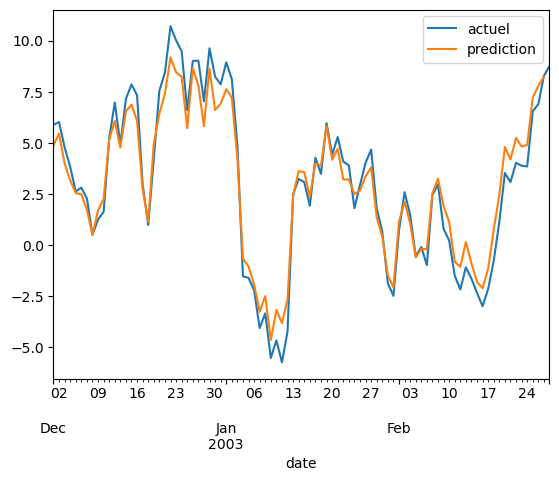

In [40]:

resultats['actuel'].plot(label='actuel')
resultats['prediction'].plot(label='prediction')
plt.legend()
plt.show()

In [41]:
def backtest(model, saison, col_entr):
    #predictions = []
    
    for i in range(1985, 2015):
        
        if ((saison.equals(hiver_entrainement)) or (saison.equals(hiver))):#2015
            k_ent = str(i+1)+'-02'
            k_val = str(i+1)+'-12'
            kk_val = str(i+2)+'-02'
            k_test = str(i+2)+'-09'
            kk_test = str(i+3)+'-11'
        elif ((saison.equals(automne_entrainement)) or (saison.equals(automne))):#2015
            k_ent = str(i)+'-11'
            k_val = str(i+1)+'-09'
            kk_val = str(i+1)+'-11'
            k_test = str(i+2)+'-09'
            kk_test = str(i+2)+'-11'
        elif ((saison.equals(printemps_entrainement)) or (saison.equals(printemps))):#2016
            k_ent = str(i)+'-05'
            k_val = str(i+1)+'-03'
            kk_val = str(i+1)+'-05'
            k_test = str(i+2)+'-03'
            kk_test = str(i+2)+'-05'
        elif ((saison.equals(ete_entrainement)) or (saison.equals(ete))):#2015
            k_ent = str(i)+'-08'
            k_val = str(i+1)+'-06'
            kk_val = str(i+1)+'-08'
            k_test = str(i+2)+'-06'
            kk_test = str(i+2)+'-08'
        
        entrainement = saison[:k_ent]
        validation = saison[k_val:kk_val]
        test = saison[k_test:kk_test]
        
        model.fit(entrainement[col_entr], validation['valeurCible'])
        preds = model.predict(test[col_entr])

        preds = pd.Series(preds, index=test.index)
        resultats = pd.concat([test['valeurCible'], preds], axis=1)
        resultats.columns = ['actuel', 'prediction']
        resultats['diff'] = (resultats['prediction'] - resultats['actuel']).abs()
        
        #predictions.append(resultats)
    return resultats

In [42]:
def backtest_2(weather, model, predictors, start=0, step=90):
    all_predictions = []
    
    for i in range(start, weather.shape[0]-8, step):
        weather = weather[:weather.shape[0]-8]
        train = weather.iloc[i:(i+step),:]
        val = weather.iloc[(i+step):(i+(2*step)),:]
        test = weather.iloc[(i+(2*step)):(i+(3*step)),:]
        
        model.fit(train[predictors], val["valeurCible"])
        preds = model.predict(test[predictors])
        
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["valeurCible"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [ ]:
backtest_2(hiver_entrainement, model_1, col_entrainement)

## Modeling Functions


In [ ]:
# train test split

train, test = temperature[:'2023'], temperature['2023']

In [ ]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)



In [ ]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [ ]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted



In [ ]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    unscaled = undo_scaling(predictions, X_test, scaler_object)
      
    get_scores(unscaled, temperature, model_name)



## XGBoost


In [ ]:
run_model(train, test, XGBRegressor( n_estimators=100,learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')

## LSTM

In [ ]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    
    get_scores(unscaled, temperature, 'LSTM')
    

In [ ]:
lstm_model(train, test)

## 2eme methode : SARIMAX

In [44]:
temperature.columns

Index(['max', 'min', 'mean', 'valeurCible', 'mois'], dtype='object')

In [45]:
temperature.shape

(13971, 5)

In [46]:
N = temperature.shape[0]
split = 0.90
training_size = round(split*N)
test_size = round((1-split)*N)

training = temperature['mean'][:training_size]
test = temperature['mean'][training_size:N]

In [47]:
def optimize_ARIMA(order_list, exog):
    results = []
    
    for order in tqdm_notebook(order_list):
        model = SARIMAX(exog, order=order).fit(disp=-1)

        aic = model.aic
        results.append([order, model.aic])
    
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [48]:
# d = 0
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

In [49]:
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
parameters_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (7, 9),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8),
 (8, 9),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9)]

In [50]:
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

order_list

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 0, 7),
 (1, 0, 8),
 (1, 0, 9),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 0, 6),
 (2, 0, 7),
 (2, 0, 8),
 (2, 0, 9),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 0, 5),
 (3, 0, 6),
 (3, 0, 7),
 (3, 0, 8),
 (3, 0, 9),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4),
 (4, 0, 5),
 (4, 0, 6),
 (4, 0, 7),
 (4, 0, 8),
 (4, 0, 9),
 (5, 0, 0),
 (5, 0, 1),
 (5, 0, 2),
 (5, 0, 3),
 (5, 0, 4),
 (5, 0, 5),
 (5, 0, 6),
 (5, 0, 7),
 (5, 0, 8),
 (5, 0, 9),
 (6, 0, 0),
 (6, 0, 1),
 (6, 0, 2),
 (6, 0, 3),
 (6, 0, 4),
 (6, 0, 5),
 (6, 0, 6),
 (6, 0, 7),
 (6, 0, 8),
 (6, 0, 9),
 (7, 0, 0),
 (7, 0, 1),
 (7, 0, 2),
 (7, 0, 3),
 (7, 0, 4),
 (7, 0, 5),
 (7, 0, 6),
 (7, 0, 7),
 (7, 0, 8),
 (7, 0, 9),
 (8, 0, 0),
 (8, 0, 1),
 (8, 0, 2),
 (8,

In [51]:
result_d_0 = optimize_ARIMA(order_list, exog = training)

result_d_0

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

KeyboardInterrupt: 

In [ ]:
# d = 1
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = training)

result_d_1

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferre

,"(p, d, q)",AIC
0,"(9, 1, 9)",51593.076687
1,"(7, 1, 9)",51606.036111
2,"(9, 1, 5)",51623.100890
3,"(8, 1, 9)",51642.150830
4,"(1, 1, 3)",51643.197521
...,...,...
95,"(0, 1, 2)",52307.078873
96,"(1, 1, 1)",52571.605374
97,"(0, 1, 1)",52716.048054
98,"(1, 1, 0)",52860.943781


# Moyenne sur les mois

<AxesSubplot: xlabel='date'>

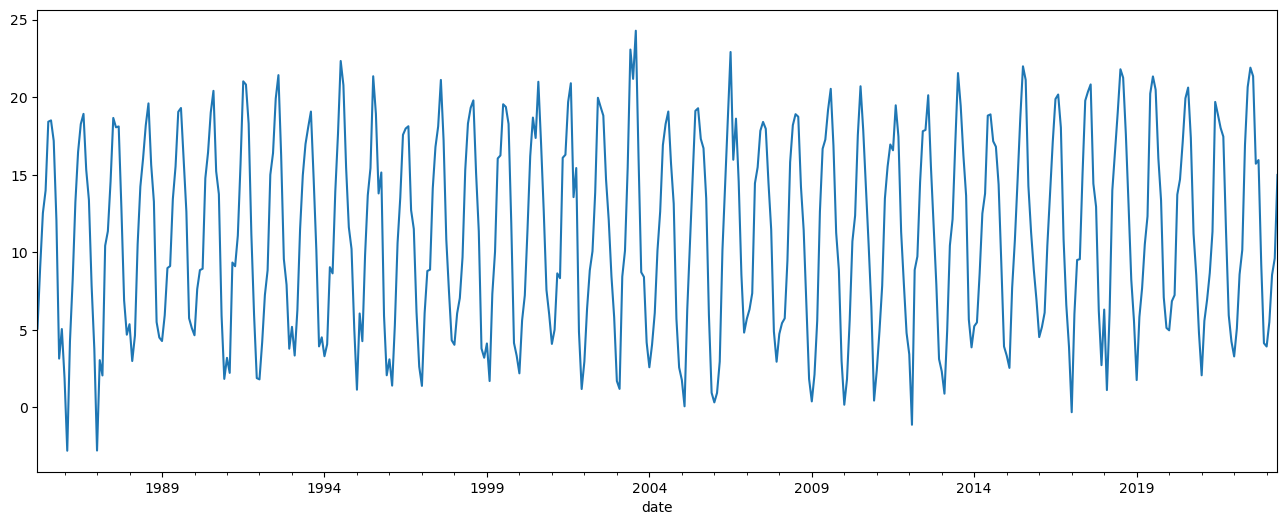

In [ ]:
moy_par_mois = temperature["mean"].resample('M').mean()
plt.figure(figsize=(16,6))
moy_par_mois.plot()

In [ ]:
moy_par_mois.shape[0]

459

In [ ]:
N = moy_par_mois.shape[0]
split = 0.90
training_size = round(split*N)
test_size = round((1-split)*N)

last_training = moy_par_mois[:training_size]
last_test = moy_par_mois[training_size:N]

In [ ]:
# d = 0 / new dataset
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_00 = optimize_ARIMA(order_list, exog = last_training)

result_d_00

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC de MEDUSA\anaconda3\lib\site-pack

LinAlgError: LU decomposition error.

In [ ]:
# d = 1 / new dataset
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_11 = optimize_ARIMA(order_list, exog = last_training)

result_d_11

In [ ]:
final_result = result_d_00.append(result_d_11)
best_models = final_result.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()
best_models

C:\Users\PC de MEDUSA\AppData\Local\Temp\ipykernel_38988\1087737579.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = result_d_00.append(result_d_11)


,"(p, d, q)",AIC
0,"(9, 1, 4)",27292.570144
1,"(9, 1, 6)",27320.865600
2,"(7, 0, 3)",27328.709772
3,"(8, 1, 1)",27345.382837
4,"(1, 1, 3)",27345.743057


In [ ]:
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [ ]:
best_model_0 = SARIMAX(last_training, order=best_model_params_0).fit()
print(best_model_0.summary())
best_model_1 = SARIMAX(last_training, order=best_model_params_1).fit()
print(best_model_1.summary())

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   mean   No. Observations:                 6710
Model:               SARIMAX(9, 1, 4)   Log Likelihood              -13632.285
Date:                Thu, 17 Aug 2023   AIC                          27292.570
Time:                        19:49:33   BIC                          27387.927
Sample:                    01-01-2003   HQIC                         27325.499
                         - 05-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2698      2.058      0.131      0.896      -3.763       4.303
ar.L2          1.5019      2.458      0.611      0.541      -3.316       6.320
ar.L3         -0.4698      0.823     -0.571      0.5

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\base\model.py:6

                               SARIMAX Results                                
Dep. Variable:                   mean   No. Observations:                 6710
Model:               SARIMAX(9, 1, 6)   Log Likelihood              -13644.433
Date:                Thu, 17 Aug 2023   AIC                          27320.866
Time:                        19:49:43   BIC                          27429.845
Sample:                    01-01-2003   HQIC                         27358.498
                         - 05-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0777      1.243      0.063      0.950      -2.359       2.514
ar.L2          1.4206      0.524      2.711      0.007       0.393       2.448
ar.L3          0.3493      1.481      0.236      0.8

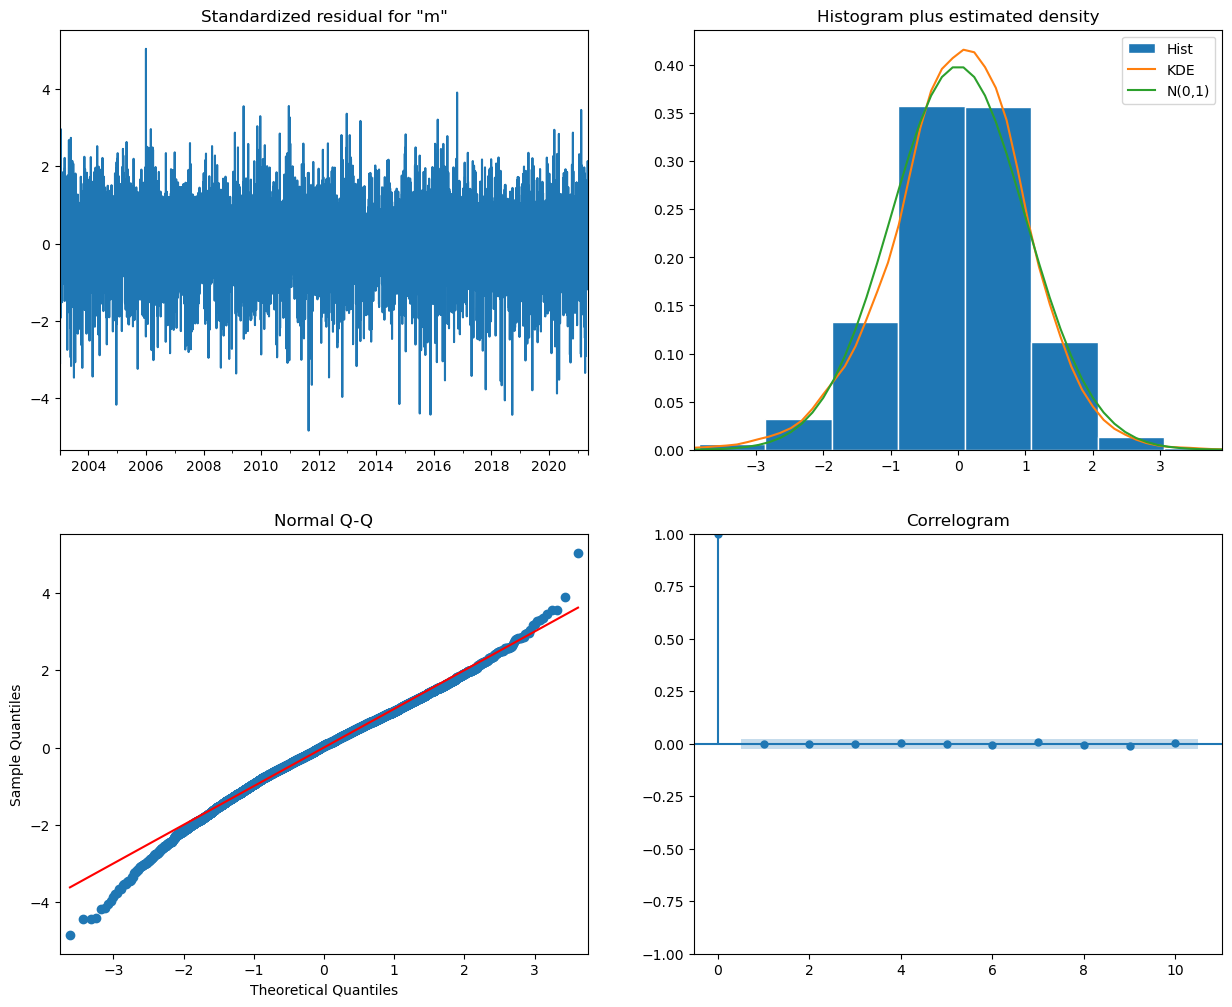

In [ ]:
best_model_0.plot_diagnostics(figsize=(15,12))
plt.show()

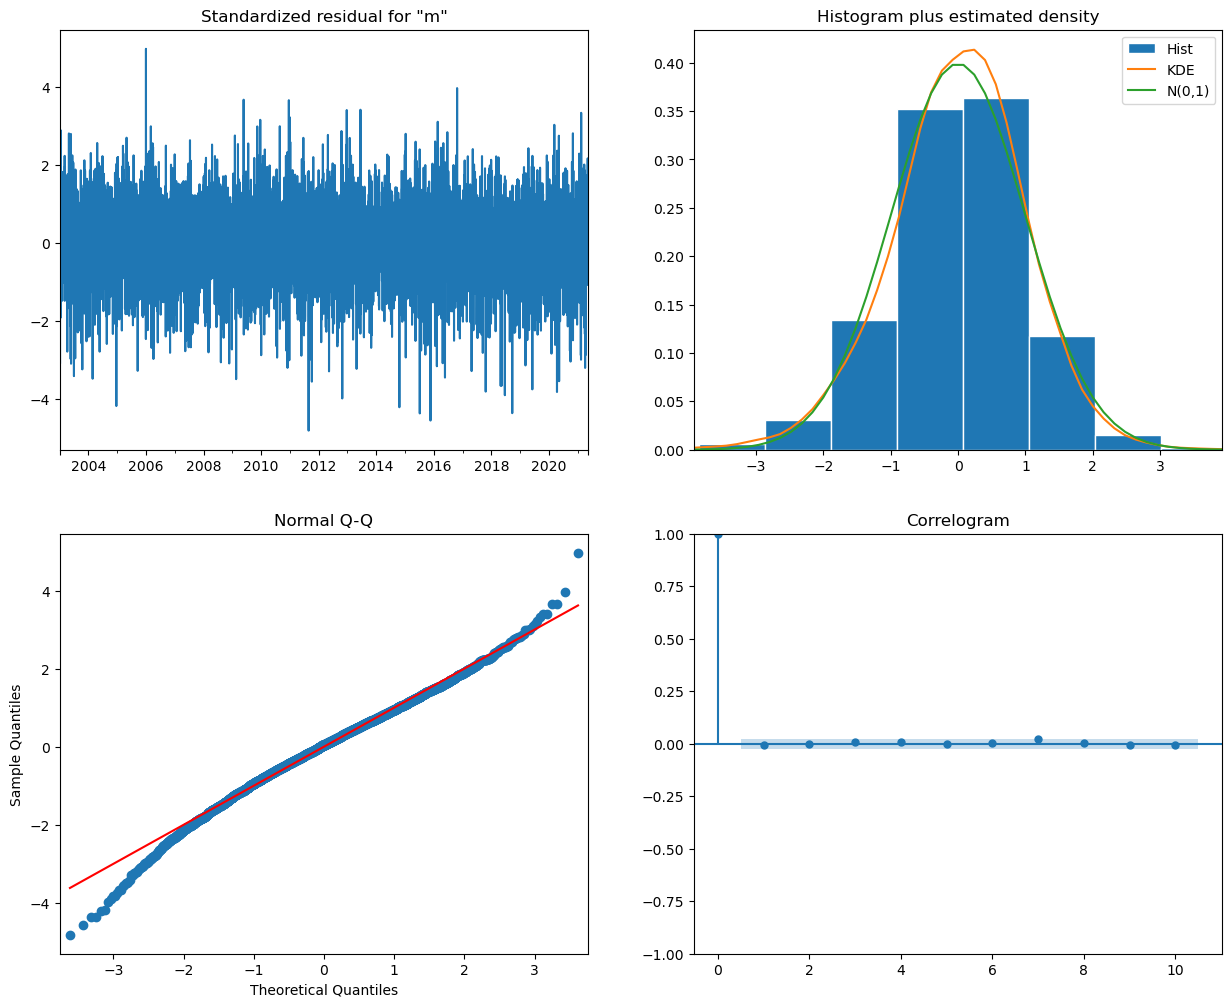

In [ ]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
forecast = best_model_0.get_prediction(start=training_size, end=training_size+test_size)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

<AxesSubplot: >

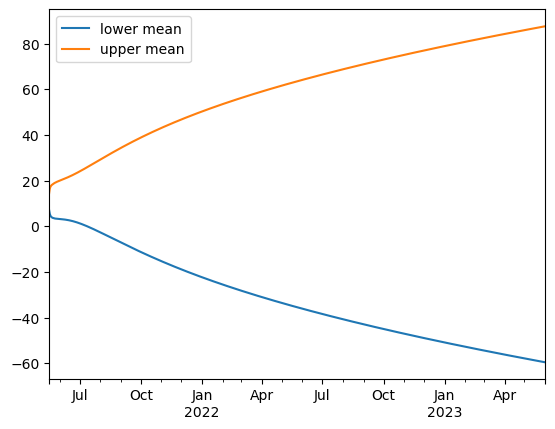

In [ ]:
ci.plot()

In [ ]:
s_forecast = best_model_1.get_prediction(start=training_size, end=training_size+test_size)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha=0.05)

<AxesSubplot: xlabel='date'>

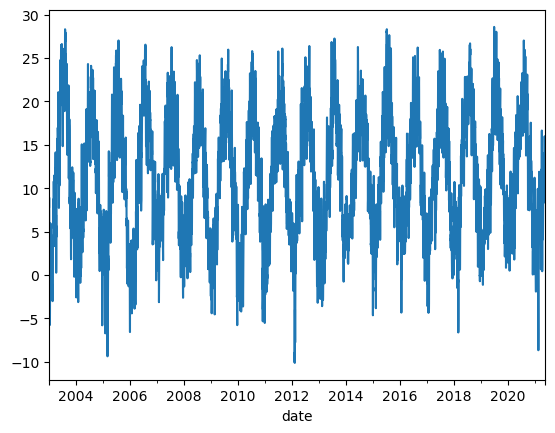

In [ ]:
last_training.plot()

In [ ]:
#last_training[training_size:training_size+test_size]
last_training.index

DatetimeIndex(['2003-01-01', '2003-01-02', '2003-01-03', '2003-01-04',
               '2003-01-05', '2003-01-06', '2003-01-07', '2003-01-08',
               '2003-01-09', '2003-01-10',
               ...
               '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09',
               '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',
               '2021-05-14', '2021-05-15'],
              dtype='datetime64[ns]', name='date', length=6710, freq=None)

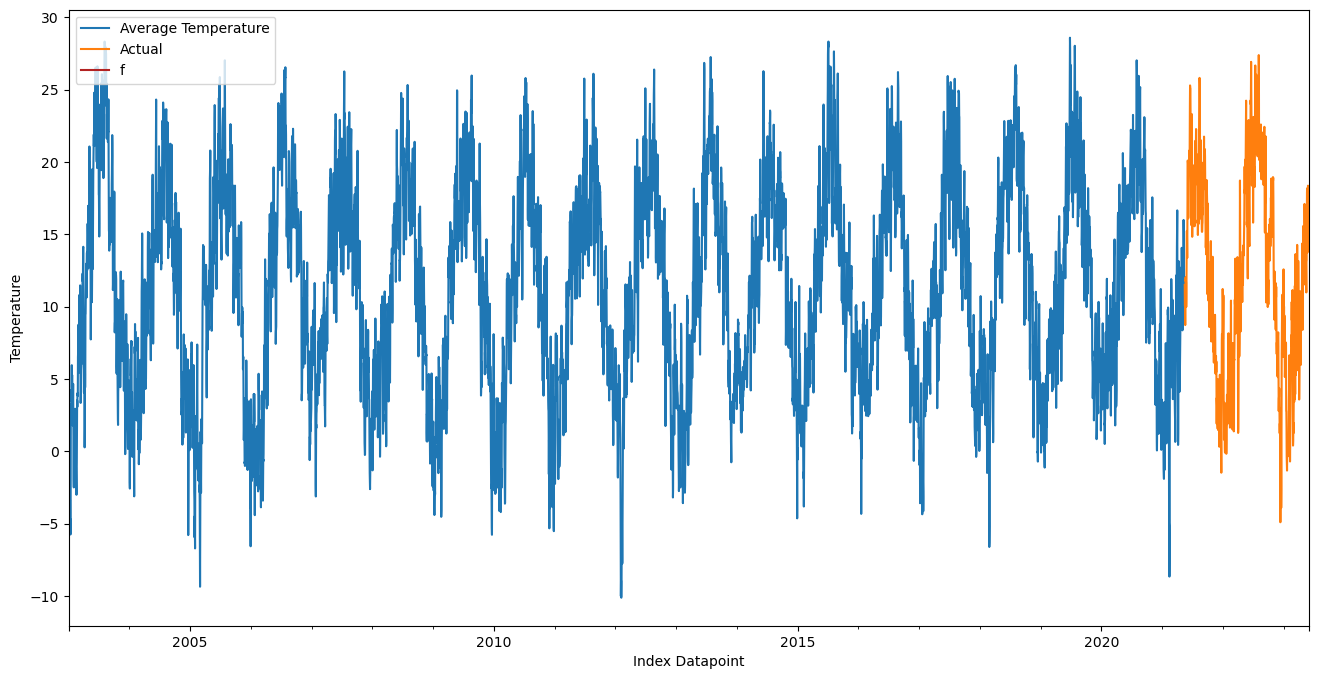

In [ ]:
#error_test=chicago_data.loc[test_date[1:].index.tolist()].AverageTemperatureUncertainty
#index_test = test_date[1:].index.tolist()
#test_set = test_series[1:]
#lower_test = test_set-error_test
#upper_test = test_set+error_test
fig, ax = plt.subplots(figsize=(16,8))
#x0 = chicago_data.AverageTemperature.index[0:training_size]
x1 = last_training.index
#ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
#plt.plot(x0, chicago_data.AverageTemperature[0:training_size],'k', label = 'Average Temperature')
last_training.plot(label = 'Average Temperature')

#plt.plot(chicago_data.AverageTemperature[training_size:training_size+fore_l], '.k', label = 'Actual')
last_test.plot(label = 'Actual')

#forec = pd.DataFrame(forec, columns=['f'], index = x1)
#forec.f.plot(ax=ax,color = 'Darkorange',label = 'Forecast (9, 1, 4) model')
#ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

s_forec = pd.DataFrame(s_forec, columns=['f'], index = x1)
s_forec.plot(ax=ax,color = 'firebrick',label = 'Forecast  (9, 1, 6) model')
#ax.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()